In [1]:
import warnings
warnings.filterwarnings("ignore")



import torch   
import numpy as np
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## En Pytorch vamos a usar Tensores
 - ### Tensor: Array multidimensional



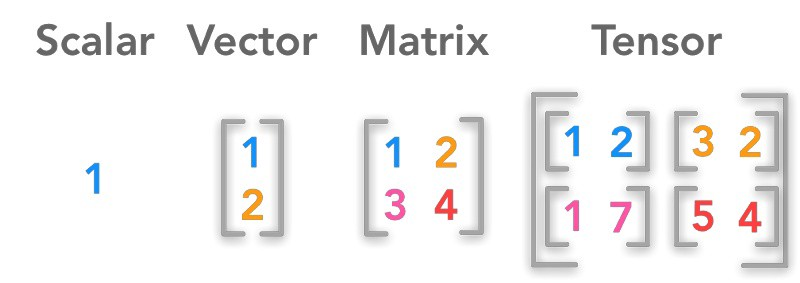

In [2]:
z = torch.zeros(5, 3)
print(z)
print(z.dtype)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
torch.float32


## Funciones de activación

 - ### Una función de activación decide si una neurona debe activarse o no. Decide si el input de la neurona es importante o no en el proceso de prediccón.


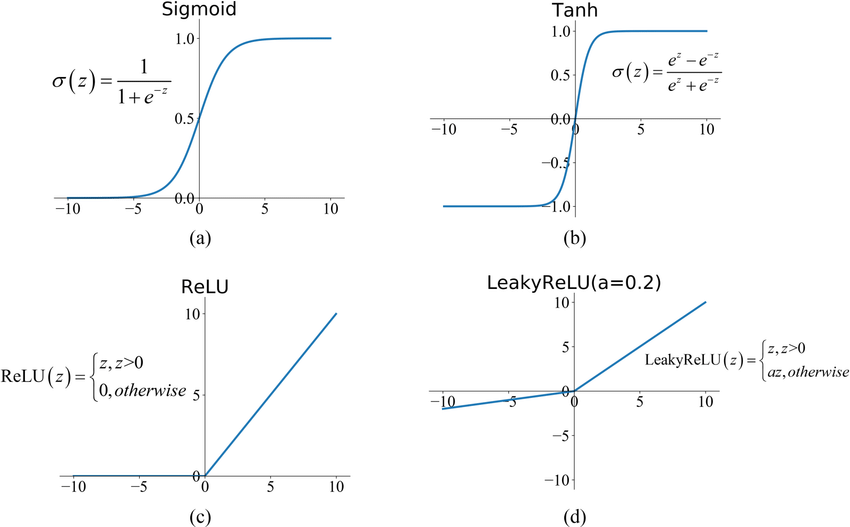

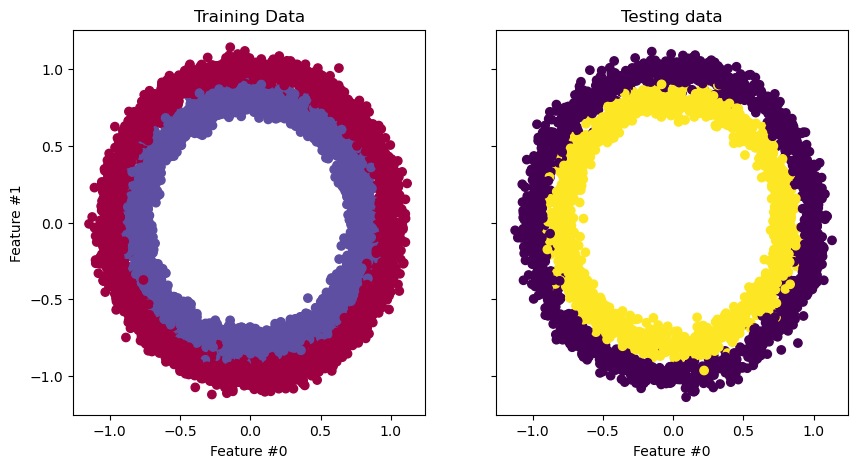

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Create a dataset with 10,000 samples.
X, y = make_circles(n_samples = 10000,
                    noise= 0.05,
                    random_state=26)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=26)

# Visualize the data.
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()

In [4]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
   
batch_size = 64

In [5]:
# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


In [6]:

input_dim = 2
hidden_dim = 10
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.input_layer = nn.Linear(in_features = input_dim, out_features = hidden_dim)
        self.hidden_1 = nn.Linear(in_features = hidden_dim, out_features = hidden_dim)
        self.output_layer = nn.Linear(in_features = hidden_dim, out_features = output_dim)
       
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_1(x)) 
        x = F.sigmoid(self.output_layer(x))
        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

NeuralNetwork(
  (input_layer): Linear(in_features=2, out_features=10, bias=True)
  (hidden_1): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)


In [7]:
learning_rate = 0.01
# Definimos nuestra función de pérdida (Binary cross entropy loss en este caso)
loss_fn = nn.BCELoss()
# El optimizador va a ser Descenso por gradiente estocástico
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # lleva los gradientes del optimizador a cero
        optimizer.zero_grad()
        # hace las predicciones pasando los datos por el modelo
        pred = model(X)
        # calcula la pérdida y los gradientes
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        # ajusta los pesos aprendidos
        optimizer.step()

print("Training Complete")

Training Complete


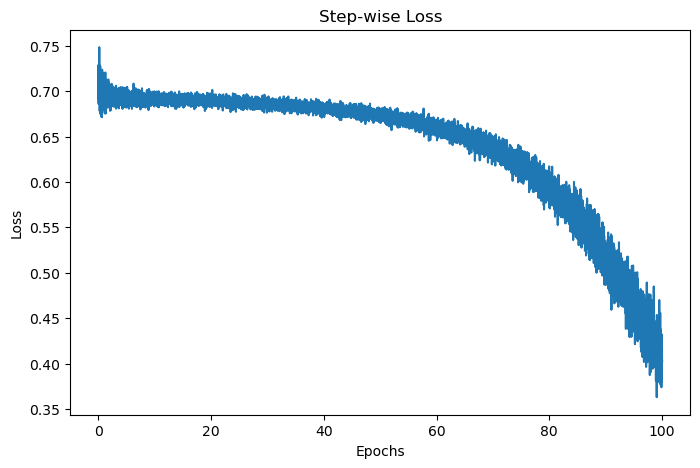

In [9]:
step = np.linspace(0, 100, 10500)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [10]:
import itertools

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns

y_pred = []
y_test = []
total = 0
correct = 0

"""
We're not training so we don't need to calculate the gradients for our outputs
"""
with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')

Accuracy of the network on the 3300 test instances: 95%


In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns


y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      1635
         1.0       0.97      0.94      0.95      1665

    accuracy                           0.95      3300
   macro avg       0.96      0.95      0.95      3300
weighted avg       0.96      0.95      0.95      3300



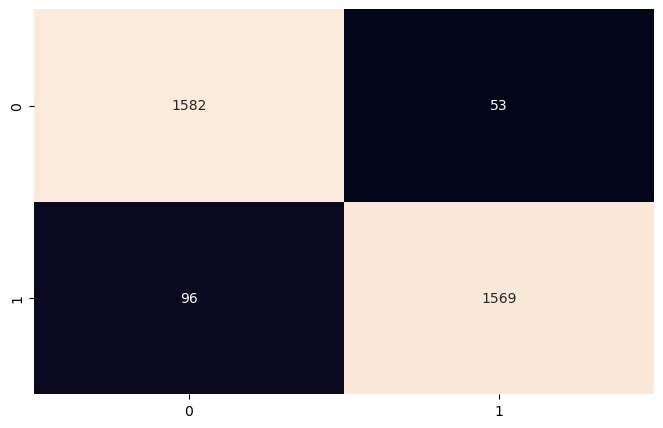

In [12]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.show()

Fuentes

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

https://appsilon.com/pytorch-neural-network-tutorial/

https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch

https://medium.com/analytics-vidhya/a-simple-neural-network-classifier-using-pytorch-from-scratch-7ebb477422d2